#Εργασία 3
###Ερώτημα 1
**Feedforward** **Neural** **Network**

Βήμα 1: Φόρτωση δεδομένων (mfccs)

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from google.colab import drive
drive.mount('/content/gdrive')

labels_map = {
    0: "hiphop",
    1: "blues",
    2: "classical",
    3: "rock_metal_hardrock",
}

def string_to_int(string_labels) :
  labels = []

  for i in range(len(string_labels)) :
    if(string_labels[i] == "hiphop"):
        labels.append(0)
    elif (string_labels[i] == "blues"):
        labels.append(1)
    elif (string_labels[i] == "classical"):
        labels.append(2)
    elif (string_labels[i] == "rock_metal_hardrock"):
        labels.append(3)

  return labels

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
trainX = np.load('/content/gdrive/MyDrive/ML/music_genre_data_di/train/mfccs/X.npy')
testX = np.load('/content/gdrive/MyDrive/ML/music_genre_data_di/test/mfccs/X.npy')
valX = np.load('/content/gdrive/MyDrive/ML/music_genre_data_di/val/mfccs/X.npy')


string_labels = np.load('/content/gdrive/MyDrive/ML/music_genre_data_di/train/mfccs/labels.npy')
trainL = string_to_int(string_labels)
string_labels = np.load('/content/gdrive/MyDrive/ML/music_genre_data_di/test/mfccs/labels.npy')
testL = string_to_int(string_labels)
string_labels = np.load('/content/gdrive/MyDrive/ML/music_genre_data_di/val/mfccs/labels.npy')
valL = string_to_int(string_labels)

train = list(zip(trainX, trainL))
test = list(zip(testX, testL))
val = list(zip(valX, valL))

train_dataloader = DataLoader(train, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test, batch_size=16, shuffle=False)
val_dataloader = DataLoader(val, batch_size=16, shuffle=True)

print('Training set has {} instances'.format(len(train_dataloader)))
print('Testning set has {} instances'.format(len(test_dataloader)))
print('Valning set has {} instances'.format(len(val_dataloader)))


Training set has 200 instances
Testning set has 86 instances
Valning set has 50 instances


Βήμα 2: Ορισμός Νευρωνικού Δικτύου

In [ ]:
import torch.nn as nn

class NeuralNetwork(nn.Module): ##NeuralNetwork iS A subclass of nn.module
    def __init__(self):
        super(NeuralNetwork, self).__init__() ## call the constructor of super
        self.flatten = nn.Flatten()
        ## image 26 --> 126 --> 32 --> 4
        self.linear_stack = nn.Sequential(
            nn.Linear(26, 128),  ##torch.nn.Linear(in_features, out_features) 26-->128
            nn.Linear(128, 32),    ## 128-->32
            nn.Linear(32, 4),     ##32 -->4
        )

    ## Every nn.Module subclass implements the operations on input data in the forward method.
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_stack(x)
        return logits

Βήμα 3: Ορισμός διαδικασίας εκπαίδευσης

In [ ]:
def train_loop(num_epochs, dataloader, model, loss_fn, optimizer, validation_check):
  size = len(dataloader.dataset)
  if (validation_check) :
    best_model = NeuralNetwork().to(device)
    torch.save(model, 'model.pth')
    best_model = torch.load('model.pth')
    (test_loss, correct, f1, conf) = test_loop(val_dataloader, model, loss_fn)
    best_score = f1
  for t in range(num_epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    for batch, (X, y) in enumerate(dataloader):
        # if using gpu dont forget to move the data there
        X = X.to(device)
        y = y.to(device)
        X = X.type(torch.FloatTensor)

        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # per 10 batches report the value of the loss function on the training set
        if batch % 10 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    if (validation_check) :
      (test_loss, correct, f1, conf) = test_loop(val_dataloader, model, loss_fn)
      if (best_score < f1) :
        torch.save(model, 'model.pth')
        best_model = torch.load('model.pth')
        best_score = f1

  print("Done!")
  if (validation_check) :
    return best_model
  else :
    return model


Βήμα 4: Ορισμός διαδικασίας αξιολόγησης

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0
    test_y=[]
    pred_y=[]

    # the no_grad command tells PyTorch that we dont want to accumulate gradients for these operations
    with torch.no_grad():
        for X, y in dataloader:

            # if using gpu dont forget to move the data there
            X = X.to(device)
            y = y.to(device)
            X = X.type(torch.FloatTensor)

            pred = model(X)
            pred_y.append(pred.argmax(1))
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            test_y.append(y)

    test_loss /= size
    correct /= size
    test_y = torch.cat(test_y)
    pred_y = torch.cat(pred_y)
    f1 = f1_score(test_y, pred_y, average = 'macro')
    conf = confusion_matrix(test_y, pred_y)

    return test_loss, correct, f1, conf

Βήμα 5: Εκπαίδευση δικτύου

In [ ]:
import time

device = 'cpu'
model = NeuralNetwork().to(device)  ##assing model to device

# define the hyperparameters of the optimization/training process

# define the loss function
loss_fn = nn.CrossEntropyLoss()

# define the learning rate
learning_rate =  0.002

# define the optimizer object
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

# define number of epochs
num_epochs = 30

start = time.time()
model = train_loop(num_epochs,train_dataloader, model, loss_fn, optimizer, 0)
(test_loss, correct, f1, conf) = test_loop(test_dataloader, model, loss_fn)
end = time.time()

print("Time:", end - start, "sec")
print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}, macro F1 score: {f1 * 100}%, \nconfusion matrix: \n{conf} \n")

Epoch 1
-------------------------------
loss: 2.062298  [    0/ 3200]
loss: 1.431544  [  160/ 3200]
loss: 1.372972  [  320/ 3200]
loss: 1.350493  [  480/ 3200]
loss: 1.417414  [  640/ 3200]
loss: 1.390511  [  800/ 3200]
loss: 1.356292  [  960/ 3200]
loss: 1.440403  [ 1120/ 3200]
loss: 1.446300  [ 1280/ 3200]
loss: 1.396332  [ 1440/ 3200]
loss: 1.373840  [ 1600/ 3200]
loss: 1.388871  [ 1760/ 3200]
loss: 1.386843  [ 1920/ 3200]
loss: 1.376619  [ 2080/ 3200]
loss: 1.416431  [ 2240/ 3200]
loss: 1.413972  [ 2400/ 3200]
loss: 1.383664  [ 2560/ 3200]
loss: 1.397853  [ 2720/ 3200]
loss: 1.398677  [ 2880/ 3200]
loss: 1.445427  [ 3040/ 3200]
Epoch 2
-------------------------------
loss: 1.392890  [    0/ 3200]
loss: 1.401597  [  160/ 3200]
loss: 1.398530  [  320/ 3200]
loss: 1.394248  [  480/ 3200]
loss: 1.377131  [  640/ 3200]
loss: 1.374767  [  800/ 3200]
loss: 1.386698  [  960/ 3200]
loss: 1.501894  [ 1120/ 3200]
loss: 1.361272  [ 1280/ 3200]
loss: 1.360161  [ 1440/ 3200]
loss: 1.376626  [ 16

Βήμα 6: Εκπαίδευση δικτύου με GPU


In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import torch.nn as nn
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import time

from google.colab import drive
drive.mount('/content/gdrive')

device = 'cuda' if torch.cuda.is_available() else 'cpu'

labels_map = {
    0: "hiphop",
    1: "blues",
    2: "classical",
    3: "rock_metal_hardrock",
}

def string_to_int(string_labels) :
  labels = []

  for i in range(len(string_labels)) :
    if(string_labels[i] == "hiphop"):
        labels.append(0)
    elif (string_labels[i] == "blues"):
        labels.append(1)
    elif (string_labels[i] == "classical"):
        labels.append(2)
    elif (string_labels[i] == "rock_metal_hardrock"):
        labels.append(3)

  return labels

trainX = np.load('/content/gdrive/MyDrive/ML/music_genre_data_di/train/mfccs/X.npy')
testX = np.load('/content/gdrive/MyDrive/ML/music_genre_data_di/test/mfccs/X.npy')
valX = np.load('/content/gdrive/MyDrive/ML/music_genre_data_di/val/mfccs/X.npy')


string_labels = np.load('/content/gdrive/MyDrive/ML/music_genre_data_di/train/mfccs/labels.npy')
trainL = string_to_int(string_labels)
string_labels = np.load('/content/gdrive/MyDrive/ML/music_genre_data_di/test/mfccs/labels.npy')
testL = string_to_int(string_labels)
string_labels = np.load('/content/gdrive/MyDrive/ML/music_genre_data_di/val/mfccs/labels.npy')
valL = string_to_int(string_labels)

train = list(zip(trainX, trainL))
test = list(zip(testX, testL))
val = list(zip(valX, valL))

train_dataloader = DataLoader(train, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test, batch_size=16, shuffle=False)
val_dataloader = DataLoader(val, batch_size=16, shuffle=True)

print('Training set has {} instances'.format(len(train_dataloader)))
print('Testning set has {} instances'.format(len(test_dataloader)))
print('Valning set has {} instances'.format(len(val_dataloader)))

class NeuralNetwork(nn.Module): ##NeuralNetwork iS A subclass of nn.module
    def __init__(self):
        super(NeuralNetwork, self).__init__() ## call the constructor of super
        self.flatten = nn.Flatten()
        ## image 26 --> 126 --> 32 --> 4
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(26, 128),  ##torch.nn.Linear(in_features, out_features) 26-->128
            nn.Linear(128, 32),    ## 128-->32
            nn.Linear(32, 4),     ##32 -->4
        )

    ## Every nn.Module subclass implements the operations on input data in the forward method.
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

def train_loop(num_epochs, dataloader, model, loss_fn, optimizer, validation_check):
  size = len(dataloader.dataset)
  for t in range(num_epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    for batch, (X, y) in enumerate(dataloader):
        # if using gpu dont forget to move the data there
        X = X.to(device)
        y = y.to(device)
        X = X.type(torch.FloatTensor)

        # Compute prediction and loss
        pred = model(X.cuda())
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # per 10 batches report the value of the loss function on the training set
        if batch % 10 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    if (validation_check) :
      if (t == 0) :
        best_model = model
        (test_loss, correct, f1, conf) = test_loop(val_dataloader, model, loss_fn)
        best_score = f1
      else :
        (test_loss, correct, f1, conf) = test_loop(val_dataloader, model, loss_fn)
        if (best_score < f1) :
          best_model = model
          best_score = f1

  print("Done!")
  if (validation_check) :
    return best_model
  else :
    return model

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0
    test_y=[]
    pred_y=[]

    # the no_grad command tells PyTorch that we dont want to accumulate gradients for these operations
    with torch.no_grad():
        for X, y in dataloader:

            # if using gpu dont forget to move the data there
            X = X.to(device)
            y = y.to(device)
            X = X.type(torch.FloatTensor)

            pred = model(X.cuda())
            pred_y.append(pred.argmax(1))
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            test_y.append(y)

    test_loss /= size
    correct /= size
    test_y = torch.cat(test_y)
    pred_y = torch.cat(pred_y)
    pred_y=pred_y.cpu()
    test_y=test_y.cpu()
    f1 = f1_score(test_y, pred_y, average = 'macro')
    conf = confusion_matrix(test_y, pred_y)

    return test_loss, correct, f1, conf


model = NeuralNetwork().to(device)  ##assing model to device

# define the hyperparameters of the optimization/training process

# define the loss function
loss_fn = nn.CrossEntropyLoss()

# define the learning rate
learning_rate =  0.002

# define the optimizer object
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

# define number of epochs
num_epochs = 30

start = time.time()
model = train_loop(num_epochs,train_dataloader, model, loss_fn, optimizer, 0)
(test_loss, correct, f1, conf) = test_loop(test_dataloader, model, loss_fn)
end = time.time()

print("Time:", end - start, "sec")
print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}, macro F1 score: {f1 * 100}%, \nconfusion matrix: \n{conf} \n")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Training set has 200 instances
Testning set has 86 instances
Valning set has 50 instances
Epoch 1
-------------------------------
loss: 1.616639  [    0/ 3200]
loss: 1.377927  [  160/ 3200]
loss: 1.376345  [  320/ 3200]
loss: 1.349498  [  480/ 3200]
loss: 1.399744  [  640/ 3200]
loss: 1.405806  [  800/ 3200]
loss: 1.365733  [  960/ 3200]
loss: 1.409770  [ 1120/ 3200]
loss: 1.405165  [ 1280/ 3200]
loss: 1.451382  [ 1440/ 3200]
loss: 1.398044  [ 1600/ 3200]
loss: 1.459242  [ 1760/ 3200]
loss: 1.379108  [ 1920/ 3200]
loss: 1.378543  [ 2080/ 3200]
loss: 1.447308  [ 2240/ 3200]
loss: 1.361426  [ 2400/ 3200]
loss: 1.365024  [ 2560/ 3200]
loss: 1.393431  [ 2720/ 3200]
loss: 1.310012  [ 2880/ 3200]
loss: 1.397218  [ 3040/ 3200]
Epoch 2
-------------------------------
loss: 1.388164  [    0/ 3200]
loss: 1.327627  [  160/ 3200]
loss: 1.462354  [  320/ 3200]
loss: 1.3

####**Σχόλια**
Παρατηρώ ότι η gpu είναι ελάχιστα πιο γρήγορη από την cpu. Το έβαλα σε ξεχωριστώ κομμάτι το gpu καθώς αν τα το τρέξω μαζί με τα άλλα μπερεύονται οι tensor και δε μεταφέρονται όλοι στο ίδιο device.

Βήμα 7: Επιλογή μοντέλου

In [ ]:
device = 'cpu'
model = NeuralNetwork().to(device)  ##assing model to device

# define the hyperparameters of the optimization/training process

# define the loss function
loss_fn = nn.CrossEntropyLoss()

# define the learning rate
learning_rate =  0.002

# define the optimizer object
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

# define number of epochs
num_epochs = 30

best_model = train_loop(num_epochs,train_dataloader, model, loss_fn, optimizer, 1)
(test_loss, correct, f1, conf) = test_loop(test_dataloader, best_model, loss_fn)

print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}, macro F1 score: {f1 * 100}%, \nconfusion matrix: \n{conf} \n")

Epoch 1
-------------------------------
loss: 1.310414  [    0/ 3200]
loss: 1.414840  [  160/ 3200]
loss: 1.380828  [  320/ 3200]
loss: 1.362303  [  480/ 3200]
loss: 1.412444  [  640/ 3200]
loss: 1.357145  [  800/ 3200]
loss: 1.391678  [  960/ 3200]
loss: 1.412890  [ 1120/ 3200]
loss: 1.330633  [ 1280/ 3200]
loss: 1.417117  [ 1440/ 3200]
loss: 1.383579  [ 1600/ 3200]
loss: 1.301989  [ 1760/ 3200]
loss: 1.386732  [ 1920/ 3200]
loss: 1.404616  [ 2080/ 3200]
loss: 1.364879  [ 2240/ 3200]
loss: 1.359104  [ 2400/ 3200]
loss: 1.355381  [ 2560/ 3200]
loss: 1.362721  [ 2720/ 3200]
loss: 1.318025  [ 2880/ 3200]
loss: 1.355970  [ 3040/ 3200]
Epoch 2
-------------------------------
loss: 1.432053  [    0/ 3200]
loss: 1.342597  [  160/ 3200]
loss: 1.356762  [  320/ 3200]
loss: 1.309948  [  480/ 3200]
loss: 1.359690  [  640/ 3200]
loss: 1.423970  [  800/ 3200]
loss: 1.322314  [  960/ 3200]
loss: 1.357082  [ 1120/ 3200]
loss: 1.310214  [ 1280/ 3200]
loss: 1.442752  [ 1440/ 3200]
loss: 1.347317  [ 16

####**Σχόλια**
Παρατηρώ οτι αν αποθηκεύσουμε το καλύτερο μοντέλο για το validation set σε κάθε εποχή τότε θα έχω λίγο καλύτεη γενίκευση από ότι πριν. Επίσης βλέπω οτι κάθε φορά που το εκτελώ έχω και διαφορετικά αποτελέσματα. Λογικά αυτό συμβαίνει γιατι κάθε φορά αρχικοποιούνται τα βάρη με διαφορετικές τιμές.

###Ερώτημα 2
**Convolutional** **Neural** **Network**

Βήμα 1: Φόρτωση δεδομένων (spectrograms)

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from google.colab import drive
drive.mount('/content/gdrive')

labels_map = {
    0: "hiphop",
    1: "blues",
    2: "classical",
    3: "rock_metal_hardrock",
}

def string_to_int(string_labels) :
  labels = []

  for i in range(len(string_labels)) :
    if(string_labels[i] == "hiphop"):
        labels.append(0)
    elif (string_labels[i] == "blues"):
        labels.append(1)
    elif (string_labels[i] == "classical"):
        labels.append(2)
    elif (string_labels[i] == "rock_metal_hardrock"):
        labels.append(3)

  return labels

Mounted at /content/gdrive


Training set has 200 instances
Testning set has 86 instances
Valning set has 50 instances


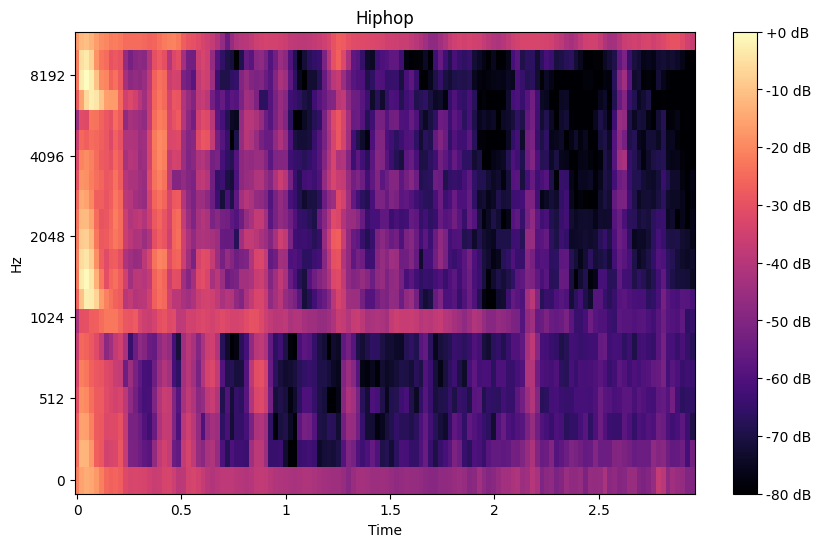

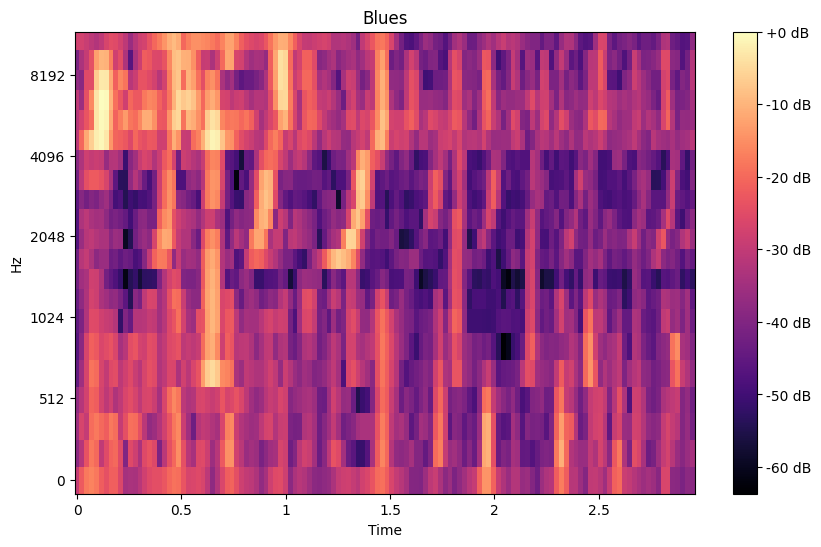

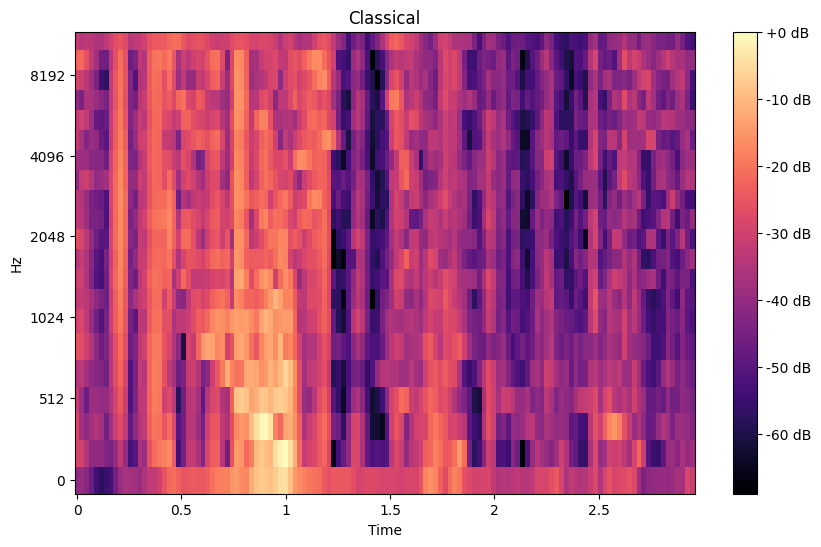

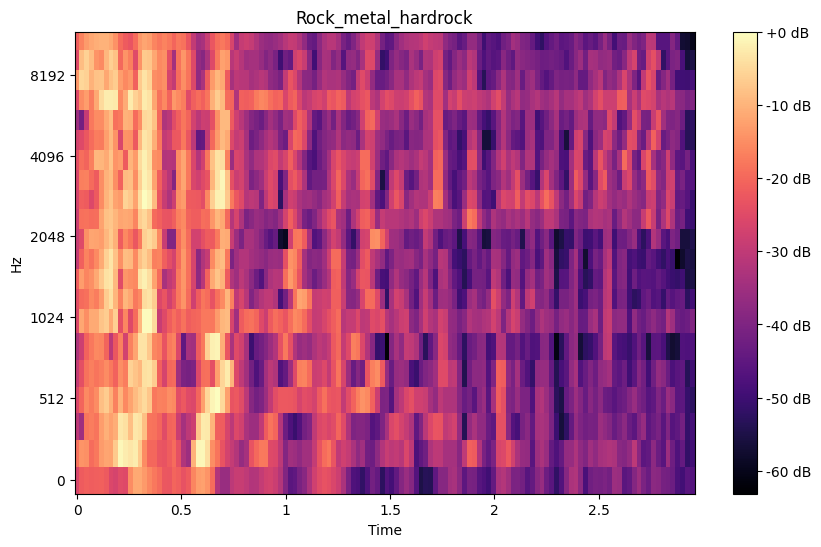

In [ ]:
import random
import librosa
import librosa.display

trainX = np.load('/content/gdrive/MyDrive/ML/music_genre_data_di/train/melgrams/X.npy')
testX = np.load('/content/gdrive/MyDrive/ML/music_genre_data_di/test/melgrams/X.npy')
valX = np.load('/content/gdrive/MyDrive/ML/music_genre_data_di/val/melgrams/X.npy')


string_labels = np.load('/content/gdrive/MyDrive/ML/music_genre_data_di/train/melgrams/labels.npy')
trainL = string_to_int(string_labels)
string_labels = np.load('/content/gdrive/MyDrive/ML/music_genre_data_di/test/melgrams/labels.npy')
testL = string_to_int(string_labels)
string_labels = np.load('/content/gdrive/MyDrive/ML/music_genre_data_di/val/melgrams/labels.npy')
valL = string_to_int(string_labels)

train = list(zip(trainX, trainL))
test = list(zip(testX, testL))
val = list(zip(valX, valL))

train_dataloader = DataLoader(train, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test, batch_size=16, shuffle=False)
val_dataloader = DataLoader(val, batch_size=16, shuffle=True)

print('Training set has {} instances'.format(len(train_dataloader)))
print('Testning set has {} instances'.format(len(test_dataloader)))
print('Valning set has {} instances'.format(len(val_dataloader)))

for i in range(1, 5) :
  flag = 0
  while (flag == 0) :
    sample_idx = random.randint(0, len(trainX))
    if ((i == 1) & (trainL[sample_idx] == 0)) :
      flag = 1
      plt.figure(figsize=(10, 6));
      plt.title("Hiphop")
      librosa.display.specshow(trainX[sample_idx], hop_length=512, x_axis='time', y_axis='mel');
      plt.colorbar(format='%+2.0f dB');
      plt.show()
    elif ((i == 2) & (trainL[sample_idx] == 1)) :
      flag = 1
      plt.figure(figsize=(10, 6));
      plt.title("Blues")
      librosa.display.specshow(trainX[sample_idx], hop_length=512, x_axis='time', y_axis='mel');
      plt.colorbar(format='%+2.0f dB');
      plt.show()
    elif ((i == 3) & (trainL[sample_idx] == 2)) :
      flag = 1
      plt.figure(figsize=(10, 6));
      plt.title("Classical")
      librosa.display.specshow(trainX[sample_idx], hop_length=512, x_axis='time', y_axis='mel');
      plt.colorbar(format='%+2.0f dB');
      plt.show()
    elif ((i == 4) & (trainL[sample_idx] == 3)) :
      flag = 1
      plt.figure(figsize=(10, 6));
      plt.title("Rock_metal_hardrock")
      librosa.display.specshow(trainX[sample_idx], hop_length=512, x_axis='time', y_axis='mel');
      plt.colorbar(format='%+2.0f dB');
      plt.show()


Βήμα 2: Ορισμός Νευρωνικού Δικτύου

In [ ]:
import torch.nn as nn

class Convolutional_Neural_Network(nn.Module):
  def __init__(self):
    super().__init__()
    # in channels, out_channels, kernel_size
    self.conv1 = nn.Conv2d(1, 16, 5)  ##in out kernel
    self.conv2 = nn.Conv2d(16, 32, 5)
    self.conv3 = nn.Conv2d(32, 64, 5)
    self.conv4 = nn.Conv2d(64, 128, 5)

    self.linear_stack = nn.Sequential(
            nn.Linear(71680, 1024),  ##torch.nn.Linear(in_features, out_features) 71680-->1024
            nn.Linear(1024, 256),    ## 1024-->256
            nn.Linear(256, 32),   ##256 -->32
            nn.Linear(32, 4),     ##32 -->4
        )

  def forward(self, x):
      x = torch.unsqueeze(x,1)

      x = self.conv1(x)
      x = self.conv2(x)
      x = self.conv3(x)
      x = self.conv4(x)

      x = x.view(x.size(0),-1)

      x = self.linear_stack(x)

      return x


Βήμα 3: Εκπαίδευση δικτύου

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0
    test_y=[]
    pred_y=[]

    # the no_grad command tells PyTorch that we dont want to accumulate gradients for these operations
    with torch.no_grad():
        for X, y in dataloader:

            # if using gpu dont forget to move the data there
            X = X.to(device)
            y = y.to(device)
            X = X.type(torch.FloatTensor)

            pred = model(X)
            pred_y.append(pred.argmax(1))
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            test_y.append(y)

    test_loss /= size
    correct /= size
    test_y = torch.cat(test_y)
    pred_y = torch.cat(pred_y)
    f1 = f1_score(test_y, pred_y, average = 'macro')
    conf = confusion_matrix(test_y, pred_y)

    return test_loss, correct, f1, conf

def train_loop(num_epochs, dataloader, model, loss_fn, optimizer, show):
  size = len(dataloader.dataset)

  best_model = Convolutional_Neural_Network().to(device)
  torch.save(model, 'model.pth')
  best_model = torch.load('model.pth')
  (test_loss, correct, f1, conf) = test_loop(val_dataloader, model, loss_fn)
  best_score = f1

  for t in range(num_epochs):
    if (show) :
      print(f"Epoch {t+1}\n-------------------------------")
    for batch, (X, y) in enumerate(dataloader):
        # if using gpu dont forget to move the data there
        X = X.to(device)
        y = y.to(device)
        X = X.type(torch.FloatTensor)

        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (show) :
          # per 10 batches report the value of the loss function on the training set
          if batch % 10 == 0:
              loss, current = loss.item(), batch * len(X)
              print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    (test_loss, correct, f1, conf) = test_loop(val_dataloader, model, loss_fn)
    if (best_score < f1) :
      torch.save(model, 'model.pth')
      best_model = torch.load('model.pth')
      best_score = f1

  if (show) :
    print("Done!")
  return best_model

In [ ]:
device = 'cpu'
model = Convolutional_Neural_Network().to(device)  ##assing model to device

# define the hyperparameters of the optimization/training process

# define the loss function
loss_fn = nn.CrossEntropyLoss()

# define the learning rate
learning_rate =  0.002

# define the optimizer object
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

# define number of epochs
num_epochs = 30

best_model = train_loop(num_epochs,train_dataloader, model, loss_fn, optimizer, 1)
(test_loss, correct, f1, conf) = test_loop(test_dataloader, best_model, loss_fn)

print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}, macro F1 score: {f1 * 100}%, \nconfusion matrix: \n{conf} \n")

Epoch 1
-------------------------------
loss: 1.305715  [    0/ 3200]
loss: 113.799164  [  160/ 3200]
loss:     nan  [  320/ 3200]
loss:     nan  [  480/ 3200]
loss:     nan  [  640/ 3200]
loss:     nan  [  800/ 3200]
loss:     nan  [  960/ 3200]
loss:     nan  [ 1120/ 3200]
loss:     nan  [ 1280/ 3200]
loss:     nan  [ 1440/ 3200]
loss:     nan  [ 1600/ 3200]
loss:     nan  [ 1760/ 3200]
loss:     nan  [ 1920/ 3200]
loss:     nan  [ 2080/ 3200]
loss:     nan  [ 2240/ 3200]
loss:     nan  [ 2400/ 3200]
loss:     nan  [ 2560/ 3200]
loss:     nan  [ 2720/ 3200]
loss:     nan  [ 2880/ 3200]
loss:     nan  [ 3040/ 3200]
Epoch 2
-------------------------------
loss:     nan  [    0/ 3200]


KeyboardInterrupt: ignored

####**Σχόλια**
Παρατηρώ οτι δεν γίναται να εκπαιδευτεί το νευρονικό δίκτυο καθώς δεν μπορώ να υπολογίσω το loss ενώ καθυστερεί πολύ γιατι στο τέλος έχω πράξει με 71.680 weights.

Βήμα 4: Pooling and padding

In [ ]:
import torch.nn as nn

class Convolutional_Neural_Network(nn.Module):
  def __init__(self):
    super().__init__()
    # in channels, out_channels, kernel_size
    self.conv1 = nn.Conv2d(1, 16, 5, padding=2)  ##in out kernel
    self.conv2 = nn.Conv2d(16, 32, 5, padding=2)
    self.conv3 = nn.Conv2d(32, 64, 5, padding=2)
    self.conv4 = nn.Conv2d(64, 128, 5, padding=2)

    self.max_pool = nn.MaxPool2d(kernel_size=2)

    self.linear_stack = nn.Sequential(
            nn.Linear(1024, 1024),  ##torch.nn.Linear(in_features, out_features) 1024-->1024
            nn.Linear(1024, 256),    ## 1024-->256
            nn.Linear(256, 32),   ##256 -->32
            nn.Linear(32, 4),     ##32 -->4
        )

  def forward(self, x):
      x = torch.unsqueeze(x,1)

      x = self.max_pool(self.conv1(x))
      x = self.max_pool(self.conv2(x))
      x = self.max_pool(self.conv3(x))
      x = self.max_pool(self.conv4(x))

      x = x.view(x.size(0),-1)

      x = self.linear_stack(x)

      return x

In [ ]:
device = 'cpu'
model = Convolutional_Neural_Network().to(device)  ##assing model to device

# define the hyperparameters of the optimization/training process

# define the loss function
loss_fn = nn.CrossEntropyLoss()

# define the learning rate
learning_rate =  0.002

# define the optimizer object
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

# define number of epochs
num_epochs = 30

model = train_loop(num_epochs,train_dataloader, model, loss_fn, optimizer, 1)
(test_loss, correct, f1, conf) = test_loop(test_dataloader, model, loss_fn)

print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}, macro F1 score: {f1 * 100}%, \nconfusion matrix: \n{conf} \n")

Epoch 1
-------------------------------
loss: 1.425421  [    0/ 3200]
loss: 1.388041  [  160/ 3200]
loss: 1.379535  [  320/ 3200]
loss: 1.334087  [  480/ 3200]
loss: 1.356656  [  640/ 3200]
loss: 1.303541  [  800/ 3200]
loss: 1.363340  [  960/ 3200]
loss: 1.418908  [ 1120/ 3200]
loss: 1.406562  [ 1280/ 3200]
loss: 1.316564  [ 1440/ 3200]
loss: 1.354895  [ 1600/ 3200]
loss: 1.280341  [ 1760/ 3200]
loss: 1.296044  [ 1920/ 3200]
loss: 1.296221  [ 2080/ 3200]
loss: 1.312634  [ 2240/ 3200]
loss: 1.468072  [ 2400/ 3200]
loss: 1.287016  [ 2560/ 3200]
loss: 1.537430  [ 2720/ 3200]
loss: 1.256598  [ 2880/ 3200]
loss: 1.304257  [ 3040/ 3200]
Epoch 2
-------------------------------
loss: 1.239696  [    0/ 3200]
loss: 1.537468  [  160/ 3200]
loss: 1.296450  [  320/ 3200]
loss: 1.224190  [  480/ 3200]
loss: 1.318533  [  640/ 3200]
loss: 1.397183  [  800/ 3200]
loss: 1.205721  [  960/ 3200]
loss: 1.434940  [ 1120/ 3200]
loss: 1.189917  [ 1280/ 3200]
loss: 1.070475  [ 1440/ 3200]
loss: 1.221181  [ 16

####**Σχόλια**
Παρατηρώ οτι πλέον το νευρονικό δίκτυο εκπαιδεύεται. Αυτό συμβαίνει γιατί μέσω του polling μειώνω την διαδσταση των δεδομένων κάθε φορα ενώ κρατάω και τα χαρακτηριστηκά μου με ενδιαφέρουν περισσότερο. Το padding έχει απλός την ιδιότητα να διατηρεί την διάσταση των δεδομένων ίδια μετά από το φιλτράρισμα. Τέλος φένεται να έχω καλή επίδοση 72.70129178985323% f1 score.

Βήμα 5: Αλγόριθμοι βελτιστοποίησης

In [ ]:
learning_rate = 0.002
num_epochs = 5
device = 'cpu'
model = Convolutional_Neural_Network().to(device)

# define the corresponding loss function and the optimizer
loss_fn = nn.CrossEntropyLoss()

correct = []
f1 = []

model = Convolutional_Neural_Network().to(device)
optimizer = torch.optim.Adadelta(model.parameters(), lr = learning_rate)
model = train_loop(num_epochs, train_dataloader, model, loss_fn, optimizer, 0)
(test_loss, c, f, conf) = test_loop(test_dataloader, model, loss_fn)
correct.append(c)
f1.append(f)

model = Convolutional_Neural_Network().to(device)
optimizer = torch.optim.Adagrad(model.parameters(), lr = learning_rate)
model = train_loop(num_epochs, train_dataloader, model, loss_fn, optimizer, 0)
(test_loss, c, f, conf) = test_loop(test_dataloader, model, loss_fn)
correct.append(c)
f1.append(f)

model = Convolutional_Neural_Network().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
model = train_loop(num_epochs, train_dataloader, model, loss_fn, optimizer, 0)
(test_loss, c, f, conf) = test_loop(test_dataloader, model, loss_fn)
correct.append(c)
f1.append(f)

model = Convolutional_Neural_Network().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr = learning_rate)
model = train_loop(num_epochs, train_dataloader, model, loss_fn, optimizer, 0)
(test_loss, c, f, conf) = test_loop(test_dataloader, model, loss_fn)
correct.append(c)
f1.append(f)

model = Convolutional_Neural_Network().to(device)
optimizer = torch.optim.Adamax(model.parameters(), lr = learning_rate)
model = train_loop(num_epochs, train_dataloader, model, loss_fn, optimizer, 0)
(test_loss, c, f, conf) = test_loop(test_dataloader, model, loss_fn)
correct.append(c)
f1.append(f)

model = Convolutional_Neural_Network().to(device)
optimizer = torch.optim.NAdam(model.parameters(), lr = learning_rate)
model = train_loop(num_epochs, train_dataloader, model, loss_fn, optimizer, 0)
(test_loss, c, f, conf) = test_loop(test_dataloader, model, loss_fn)
correct.append(c)
f1.append(f)

model = Convolutional_Neural_Network().to(device)
optimizer = torch.optim.RAdam(model.parameters(), lr = learning_rate)
model = train_loop(num_epochs, train_dataloader, model, loss_fn, optimizer, 0)
(test_loss, c, f, conf) = test_loop(test_dataloader, model, loss_fn)
correct.append(c)
f1.append(f)

model = Convolutional_Neural_Network().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
model = train_loop(num_epochs, train_dataloader, model, loss_fn, optimizer, 0)
(test_loss, c, f, conf) = test_loop(test_dataloader, model, loss_fn)
correct.append(c)
f1.append(f)

print("{:<20} {:<20} {:<20} {:<20} {:<20} {:<20} {:<20} {:<20} {:<20}".format("Optimizer", "Adadelta", "Adagrad", "Adam", "AdamW", "Adamax", "NAdam", "RAdam", "SGD"))
print("{:<20} {:<20} {:<20} {:<20} {:<20} {:<20} {:<20} {:<20} {:<20}".format("Accuracy", correct[0], correct[1], correct[2], correct[3], correct[4], correct[5], correct[6], correct[7]))
print("{:<20} {:<20} {:<20} {:<20} {:<20} {:<20} {:<20} {:<20} {:<20}".format("F1", f1[0], f1[1], f1[2], f1[3], f1[4], f1[5], f1[6], f1[7]))

Optimizer            Adadelta             Adagrad              Adam                 AdamW                Adamax               NAdam                RAdam                SGD                 
Accuracy             0.5152616279069767   0.7056686046511628   0.7441860465116279   0.7042151162790697   0.6758720930232558   0.7027616279069767   0.7085755813953488   0.6031976744186046  
F1                   0.5140725517965565   0.6992153380535285   0.7421340420685563   0.6963701369296369   0.6842538484370494   0.6931185308522044   0.7067158711120278   0.59472217531418    


####**Σχόλια**
Παρατηρώ οτι ο Adam έχει την καλύτερη επίδοση ενώ ο Adadelta την χειρότερη. Οι άλλοι έχουν παρόμοια επίδοση.